### Dataset Introduction

The dataset is 1,000,000 rows but a sample size of 10000 is used to save time. However, it is stratified to maintain the same fraud ratio.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE, trustworthiness

df = pd.read_csv('data/card_transdata.csv')

# Get counts of fraud and non-fraud cases
fraud_count = df['fraud'].value_counts()
min_count = fraud_count.min()

# Separate fraud and non-fraud cases
fraud_df = df[df['fraud'] == 1].sample(n=5000, random_state=42)
non_fraud_df = df[df['fraud'] == 0].sample(n=5000, random_state=42)

# Combine the balanced datasets
df = pd.concat([fraud_df, non_fraud_df])

# Shuffle the final dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

### Standardization
This block normalizes the numeric features using StandardScaler to ensure that the Random Forest algorithm performs effectively. StandardScaler normalizes the data such that the Mean equals 0 and the Standard Deviation equals 1. The binary columns are left unchanged.

In [53]:
# separate features and labels
X = df.drop(columns=['fraud'], axis=1)  
y = df['fraud'] 

# separate binary columns
binary_columns = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]

# separate continuous columns
continuous_columns = [col for col in X.columns if col not in binary_columns]

# scale only the continuous columns
scaler = StandardScaler()
X_scaled_continuous = scaler.fit_transform(df[continuous_columns])

# combine binary and scaled continuous data
X_scaled = pd.concat(
    [pd.DataFrame(X_scaled_continuous, columns=continuous_columns), X[binary_columns].reset_index(drop=True)],
    axis=1
)

# check that the classification labels were split properly
print("\nValue Counts for Target Labels:")
print(y.value_counts())
print(f"Fraud ratio: {y.mean()}")


Value Counts for Target Labels:
fraud
0.0    5000
1.0    5000
Name: count, dtype: int64
Fraud ratio: 0.5


### Dimensionality Reduction Functions

In [54]:
def apply_pca(X, variance_threshold): # apply PCA dimension reduction to a given dataset
    pca = PCA(n_components=variance_threshold)
    X_pca = pca.fit_transform(X)
    return X_pca, pca

def apply_tsne(X, perplexity, learning_rate=200): # pply t-SNE dimension reduction to a given dataset
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, learning_rate=learning_rate)
    X_tsne = tsne.fit_transform(X)
    return X_tsne, tsne

### Modeling Functions

In [55]:
def run_random_forest_cv(X, y, n_estimators, max_depth, cv=5, scoring='accuracy'):
    # create the corresponding rf classifier
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    
    # if scoring is a single string, convert it to a list for consistency
    single_metric = False
    if isinstance(scoring, str):
        scoring = [scoring]
        single_metric = True

    results = cross_validate(rf, X, y, cv=cv, scoring=scoring)
    # create a dictionary for the mean scores of each scoring metric with key "test_{metric}"
    mean_scores = {metric: np.mean(results[f'test_{metric}']) for metric in scoring}

    if single_metric:
        return list(mean_scores.values())[0]  # return the single metric value
    else:
        return mean_scores # otherwise return dictionary with mean_scores

def grid_search_random_forest(X, y, n_estimators_range, max_depth_range, method_name="", scoring='accuracy', verbose=True):
    results = []
    aggregated_performance = {}
    # loop through all combinations of hyperparameters
    for n_estimators in n_estimators_range:
        for depth in max_depth_range:
            # calculate score for specific combination
            score = run_random_forest_cv(X, y, n_estimators, depth, cv=5, scoring=scoring)
            
            # in case there are multiple scores from the rf cv, display the first one
            displayed_score = score if isinstance(score, float) else next(iter(score.values()))

            results.append((method_name, n_estimators, depth, displayed_score))

            if verbose:
                print(
                    f"{method_name} - n_estimators: {n_estimators}, max_depth: {depth}, "
                    f"Mean: {displayed_score:.4f}"
                )

            # update aggregated performance with the score
            if (n_estimators, depth) not in aggregated_performance:
                aggregated_performance[(n_estimators, depth)] = []
            aggregated_performance[(n_estimators, depth)].append(displayed_score)

    return results, aggregated_performance

def run_dimensionality_reduction_and_cv(X, y, method=None, n_splits=5,
                                        n_estimators=None, max_depth=None,
                                        pca_threshold=None, tsne_perplexity=None):
    # apply corresponding dimension reduction
    if method == "PCA":
        print("Applying PCA")
        X_reduced, _ = apply_pca(X, pca_threshold)
    elif method == "TSNE":
        print("Applying t-SNE")
        X_reduced, _ = apply_tsne(X, tsne_perplexity)
    elif method is None:
        print("No dimensionality reduction")
        X_reduced = X
    else:
        raise ValueError("Method must be 'PCA', 'TSNE', or None")

    X_reduced = np.array(X_reduced)
    y_np = np.array(y)

    # perform a stratifiedkfold for cv to split the data into validation sets while maintaining the original class distribution
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    print(f"\nRunning Cross-Validation ({'No Dimensionality Reduction' if method is None else method})")
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_reduced, y)):
        print(f"Fold {fold + 1}/{n_splits}")
        X_train, X_val = X_reduced[train_idx], X_reduced[val_idx]
        y_train, y_val = y_np[train_idx], y_np[val_idx]

        rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)

        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred, pos_label=1, zero_division=0)
        recall = recall_score(y_val, y_pred, pos_label=1, zero_division=0)
        f1 = f1_score(y_val, y_pred, pos_label=1, zero_division=0)
        fold_results.append((accuracy, precision, recall, f1))

        print(f"Fold Metrics - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    avg_metrics = np.mean(fold_results, axis=0)
    print(f"\nAverage Metrics Across Folds: Accuracy: {avg_metrics[0]:.4f}, Precision: {avg_metrics[1]:.4f}, Recall: {avg_metrics[2]:.4f}, F1-Score: {avg_metrics[3]:.4f}")
    return avg_metrics

def evaluate_on_test_set(X_train, y_train, X_test, y_test, method=None,
                         n_estimators=100, max_depth=None,
                         pca_threshold=None, tsne_perplexity=None):
    # apply the approriate dimension reduction if necessary
    if method == "PCA":
        X_train, pca_obj = apply_pca(X_train, pca_threshold)
        X_test = pca_obj.transform(X_test)
    elif method == "t-SNE":
        X_train, _ = apply_tsne(X_train, tsne_perplexity)
        X_test, _ = apply_tsne(X_test, tsne_perplexity)

    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    return cm, X_test, y_pred, rf


### Graphing Functions

In [56]:
def plot_line_performance(x_values, y_values, title, xlabel, ylabel, labels=None):
    plt.figure(figsize=(10,6))
    if labels is None:
        labels = [None]*len(y_values)
    for y, lbl in zip(y_values, labels):
        plt.plot(x_values, y, marker='o', label=lbl)
    if any(labels):
        plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

def plot_conf_matrix(cm, class_names=["Non-Fraud","Fraud"], title="Confusion Matrix"):
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


### PCA Optimization
PCA is run with various combinations of retained variance thresholds and hyperparameters to determine the optimal set of parameters for Random Forest with a PCA approach based primarily on the accuracy, which measures the proportion of correct predictions (both positive and negative) the model makes out of all predictions. The best combination of parameters is maintained for later testing.

PCA Threshold: 0.7, n_estimators: 50, max_depth: None, Mean Accuracy: 0.9528, Retained: 3, Removed: 4
PCA Threshold: 0.7, n_estimators: 50, max_depth: 10, Mean Accuracy: 0.9532, Retained: 3, Removed: 4
PCA Threshold: 0.7, n_estimators: 50, max_depth: 20, Mean Accuracy: 0.9531, Retained: 3, Removed: 4
PCA Threshold: 0.7, n_estimators: 100, max_depth: None, Mean Accuracy: 0.9534, Retained: 3, Removed: 4
PCA Threshold: 0.7, n_estimators: 100, max_depth: 10, Mean Accuracy: 0.9533, Retained: 3, Removed: 4
PCA Threshold: 0.7, n_estimators: 100, max_depth: 20, Mean Accuracy: 0.9529, Retained: 3, Removed: 4
PCA Threshold: 0.7, n_estimators: 150, max_depth: None, Mean Accuracy: 0.9538, Retained: 3, Removed: 4
PCA Threshold: 0.7, n_estimators: 150, max_depth: 10, Mean Accuracy: 0.9531, Retained: 3, Removed: 4
PCA Threshold: 0.7, n_estimators: 150, max_depth: 20, Mean Accuracy: 0.9540, Retained: 3, Removed: 4
PCA Threshold: 0.8, n_estimators: 50, max_depth: None, Mean Accuracy: 0.9528, Retained: 

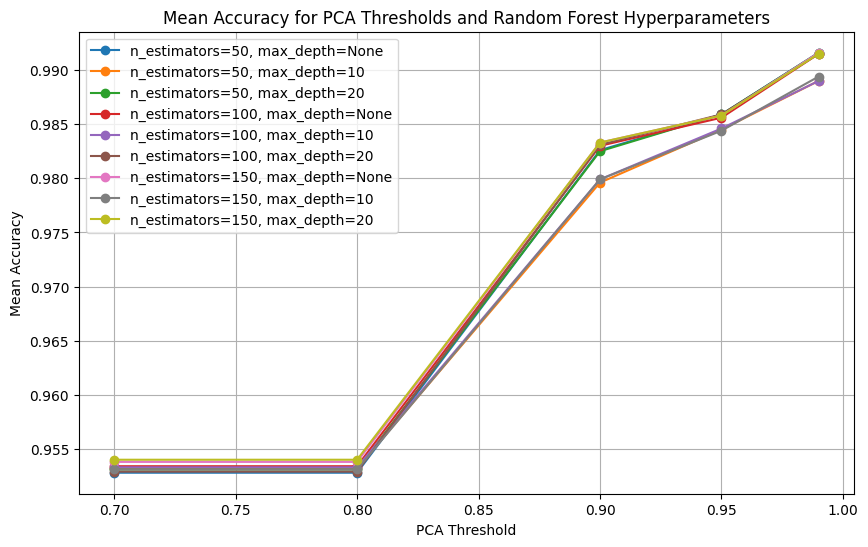

In [57]:
# PCA thresholds for testing
pca_thresholds = [0.70, 0.80, 0.90, 0.95, 0.99]

# hyperparameters for random forest
n_estimators_range = [50, 100, 150]
max_depth_range = [None, 10, 20]

# to store (pca_threshold, n_estimators, max_depth, mean_accuracy)
pca_results = []  

original_components = X_scaled.shape[1]

for pca_threshold in pca_thresholds:
    X_pca, pca_obj = apply_pca(X_scaled, pca_threshold)
    # list to keep track of which components are retained or removed
    retained_components = pca_obj.n_components_
    removed_components = original_components - retained_components

    # perform grid search with PCA
    pca_search, _ = grid_search_random_forest(
        X_pca, y, 
        n_estimators_range, max_depth_range, 
        method_name="PCA", verbose=False
    )
    
    # extract and store the results from each entrys
    for entry in pca_search:
        method, n_est, depth, acc = entry
        pca_results.append((pca_threshold, n_est, depth, acc))

    # print out metrics for each combination of PCA threshold and hyperparameters
    for (threshold, n_est, depth, acc) in [res for res in pca_results if res[0] == pca_threshold]:
        print(f"PCA Threshold: {threshold}, n_estimators: {n_est}, max_depth: {depth}, Mean Accuracy: {acc:.4f}, "
              f"Retained: {retained_components}, Removed: {removed_components}")

# find the best PCA values based on accuracy, and its corresponding hyperparameters
best_pca_trial = max(pca_results, key=lambda x: x[3])
best_pca_threshold, best_n_estimators_pca, best_max_depth_pca, best_accuracy_pca = best_pca_trial

print(f"\nBest PCA Threshold: {best_pca_threshold}, Best n_estimators: {best_n_estimators_pca}, "
      f"Best max_depth: {best_max_depth_pca}, Best Mean Accuracy: {best_accuracy_pca:.4f}")

results_array = np.array(pca_results, dtype=object)
plt.figure(figsize=(10, 6))
for n_estimators in n_estimators_range:
    for max_depth in max_depth_range:
        indices = (results_array[:, 1] == n_estimators) & (results_array[:, 2] == max_depth)
        thresholds = results_array[indices][:, 0]
        accuracies = results_array[indices][:, 3].astype(float)
        plt.plot(thresholds, accuracies, marker='o', label=f'n_estimators={n_estimators}, max_depth={max_depth}')

plt.title("Mean Accuracy for PCA Thresholds and Random Forest Hyperparameters")
plt.xlabel("PCA Threshold")
plt.ylabel("Mean Accuracy")
plt.legend()
plt.grid()
plt.show()

The number of estimators or depth did not seem to have a real effect on the mean accuracy compared to increasing the PCA threshold. The base accuracy is already high so applying the model to the PCA reduced dataset seems very well-suited for this problem. 

### t-SNE Optimization
t-SNE is run with various combinations of perplexities and hyperparameters to determine the optimal set of parameters for Random Forest with a t-SNE approach based primarily on the silhouette score and the ARI. The trustworthiness is useful to verify that the local structure of the data is properly reflected after the dimension reduction, which is important for visualization, but the other metrics better measure how well the data is preservered after being reduced. 

t-SNE Perplexity: 5, n_estimators: 50, max_depth: None, Mean Accuracy: 0.9897, Trustworthiness: 0.9996
t-SNE Perplexity: 5, n_estimators: 50, max_depth: 10, Mean Accuracy: 0.9875, Trustworthiness: 0.9996
t-SNE Perplexity: 5, n_estimators: 50, max_depth: 20, Mean Accuracy: 0.9897, Trustworthiness: 0.9996
t-SNE Perplexity: 5, n_estimators: 100, max_depth: None, Mean Accuracy: 0.9900, Trustworthiness: 0.9996
t-SNE Perplexity: 5, n_estimators: 100, max_depth: 10, Mean Accuracy: 0.9877, Trustworthiness: 0.9996
t-SNE Perplexity: 5, n_estimators: 100, max_depth: 20, Mean Accuracy: 0.9900, Trustworthiness: 0.9996
t-SNE Perplexity: 5, n_estimators: 150, max_depth: None, Mean Accuracy: 0.9898, Trustworthiness: 0.9996
t-SNE Perplexity: 5, n_estimators: 150, max_depth: 10, Mean Accuracy: 0.9882, Trustworthiness: 0.9996
t-SNE Perplexity: 5, n_estimators: 150, max_depth: 20, Mean Accuracy: 0.9898, Trustworthiness: 0.9996
t-SNE Perplexity: 10, n_estimators: 50, max_depth: None, Mean Accuracy: 0.9892,

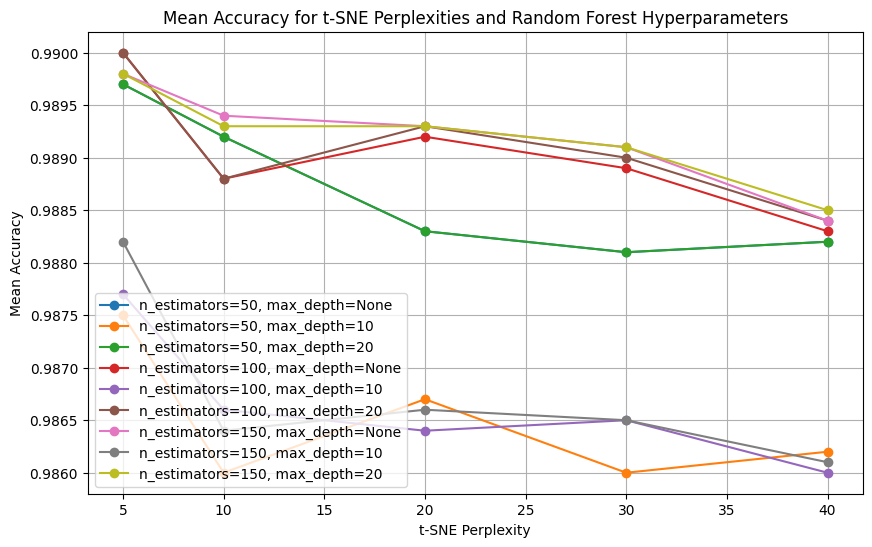

In [58]:
# t-SNE perplexities and RF hyperparameters
tsne_perplexities = [5, 10, 20, 30, 40]
n_estimators_range = [50, 100, 150]
max_depth_range = [None, 10, 20]

# store results as (perplexity, n_estimators, max_depth, mean_accuracy, trustworthiness)
tsne_results = []

for perplexity in tsne_perplexities:
    # apply t-SNE to transform the dataset
    X_tsne, tsne_obj = apply_tsne(X_scaled, perplexity)
    
    trust = trustworthiness(X_scaled, X_tsne, n_neighbors=5)
    
    # perform grid search with tsne reduced dataset
    tsne_search_results, _ = grid_search_random_forest(
        X_tsne, y,
        n_estimators_range, max_depth_range,
        method_name="t-SNE (perplexity={})".format(perplexity),
        verbose=False
    )

    # extract and store the results from each entry
    for entry in tsne_search_results:
        method, n_est, depth, acc = entry
        tsne_results.append((perplexity, n_est, depth, acc, trust))

    # print out results for the current perplexity
    for (perplexity, n_est, depth, acc, tw) in [res for res in tsne_results if res[0] == perplexity]:
        print(f"t-SNE Perplexity: {perplexity}, n_estimators: {n_est}, max_depth: {depth}, Mean Accuracy: {acc:.4f}, Trustworthiness: {tw:.4f}")

# find the best combination based on accuracy
best_tsne_trial = max(tsne_results, key=lambda x: x[3])  # maximize accuracy
best_tsne_perplexity, best_n_estimators_tsne, best_max_depth_tsne, best_accuracy_tsne, best_trust_tsne = best_tsne_trial

print(f"\nBest t-SNE Perplexity: {best_tsne_perplexity}, Best n_estimators: {best_n_estimators_tsne}, "
      f"Best max_depth: {best_max_depth_tsne}, Best Mean Accuracy: {best_accuracy_tsne:.4f}, "
      f"Best Trustworthiness: {best_trust_tsne:.4f}")

tsne_results_array = np.array(tsne_results, dtype=object)
plt.figure(figsize=(10, 6))
for n_estimators in n_estimators_range:
    for max_depth in max_depth_range:
        indices = (tsne_results_array[:, 1] == n_estimators) & (tsne_results_array[:, 2] == max_depth)
        perplexities = tsne_results_array[indices][:, 0]
        accuracies = tsne_results_array[indices][:, 3].astype(float)
        plt.plot(perplexities, accuracies, marker='o', label=f'n_estimators={n_estimators}, max_depth={max_depth}')

plt.title("Mean Accuracy for t-SNE Perplexities and Random Forest Hyperparameters")
plt.xlabel("t-SNE Perplexity")
plt.ylabel("Mean Accuracy")
plt.legend()
plt.grid()
plt.show()


On average, accuracy seems to slightly decrease as you increase the t-SNE perplexities. This could be because higher perplexities causes t-SNE to focus on larger structures of data, which can smooth out differences between points and lead to a loss of information.

### RandomForest Hyperparameter Refinement
This block runs another grid search to find the optimal depth and amount of trees in the forest based on the optimal PCA and t-SNE parameters previously calculated.


Refining hyperparameters for PCA, t-SNE, and No Reduction
No Reduction - n_estimators: 50, max_depth: None, Mean: 0.9988
No Reduction - n_estimators: 50, max_depth: 10, Mean: 0.9991
No Reduction - n_estimators: 50, max_depth: 20, Mean: 0.9988
No Reduction - n_estimators: 50, max_depth: 30, Mean: 0.9988
No Reduction - n_estimators: 100, max_depth: None, Mean: 0.9992
No Reduction - n_estimators: 100, max_depth: 10, Mean: 0.9992
No Reduction - n_estimators: 100, max_depth: 20, Mean: 0.9991
No Reduction - n_estimators: 100, max_depth: 30, Mean: 0.9992
No Reduction - n_estimators: 150, max_depth: None, Mean: 0.9994
No Reduction - n_estimators: 150, max_depth: 10, Mean: 0.9994
No Reduction - n_estimators: 150, max_depth: 20, Mean: 0.9993
No Reduction - n_estimators: 150, max_depth: 30, Mean: 0.9994
No Reduction - n_estimators: 200, max_depth: None, Mean: 0.9993
No Reduction - n_estimators: 200, max_depth: 10, Mean: 0.9994
No Reduction - n_estimators: 200, max_depth: 20, Mean: 0.9993
No Redu

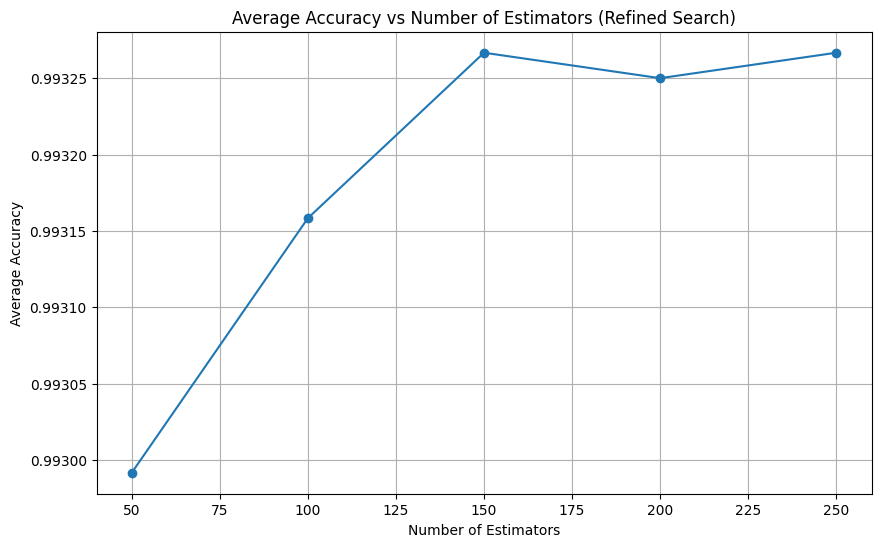

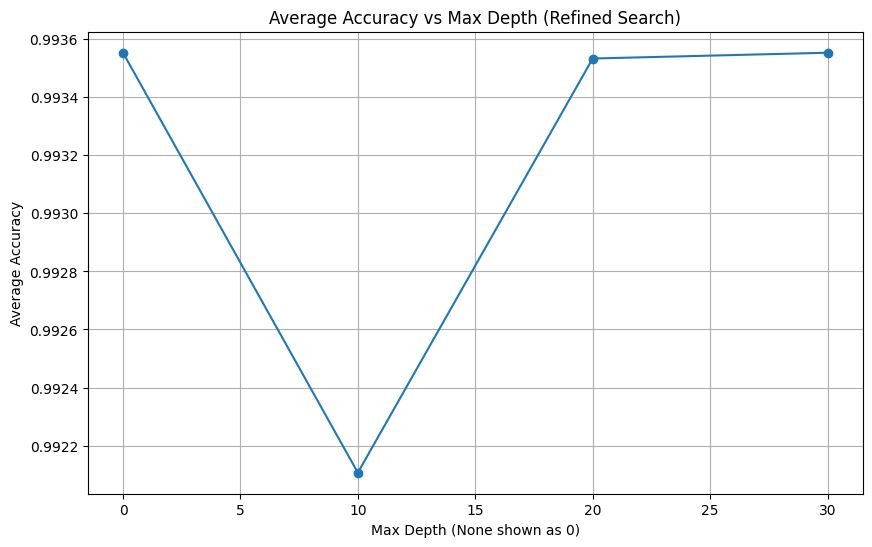


Refined Best No Reduction - n_estimators: 150, max_depth: None
Refined Best PCA - n_estimators: 250, max_depth: None
Refined Best t-SNE - n_estimators: 100, max_depth: None


In [59]:
print("\nRefining hyperparameters for PCA, t-SNE, and No Reduction")

# broader hyperparameter ranges
n_estimators_range = [50, 100, 150, 200, 250]
max_depth_range = [None, 10, 20, 30]

# refine for no dimensionality reduction
no_reduction_results, no_reduction_agg = grid_search_random_forest(X_scaled, y,  n_estimators_range, max_depth_range, "No Reduction")

# refine for PCA
X_pca_best, _ = apply_pca(X_scaled, best_pca_threshold)
pca_refined_results, pca_agg = grid_search_random_forest(X_pca_best, y, n_estimators_range, max_depth_range, "PCA")

# refine for t-SNE
X_tsne_best, _ = apply_tsne(X_scaled, best_tsne_perplexity)
tsne_refined_results, tsne_agg = grid_search_random_forest(X_tsne_best, y, n_estimators_range, max_depth_range, "t-SNE")

# combine the aggregation dictionaries from all three methods
all_aggregated_accuracies = {}
for agg_dict in [no_reduction_agg, pca_agg, tsne_agg]:
    for (n_est, depth), accuracy_list in agg_dict.items():
        if (n_est, depth) not in all_aggregated_accuracies:
            all_aggregated_accuracies[(n_est, depth)] = []
        all_aggregated_accuracies[(n_est, depth)].extend(accuracy_list)

# each dictionary stores the average performance of either all of the n_estimators or the max_depths
average_performance_estimators = {n: [] for n in n_estimators_range}
average_performance_depth = {d: [] for d in max_depth_range}

for (n_estimators, max_depth), accuracies in all_aggregated_accuracies.items():
    # calculates the mean accuracies and then appends them to the corresponding lists
    avg_accuracy = np.mean(accuracies)
    average_performance_estimators[n_estimators].append(avg_accuracy)
    average_performance_depth[max_depth].append(avg_accuracy)

# each dictionary contains a single mean accuracy for each n_estimator or avg_depth value
avg_estimators = {n: np.mean(average_performance_estimators[n]) for n in n_estimators_range}
avg_depth = {d: np.mean(average_performance_depth[d]) for d in max_depth_range}

# plot the average accuracy for different numbers of estimators
plt.figure(figsize=(10, 6))
plt.plot(list(avg_estimators.keys()), list(avg_estimators.values()), marker="o")
plt.title("Average Accuracy vs Number of Estimators (Refined Search)")
plt.xlabel("Number of Estimators")
plt.ylabel("Average Accuracy")
plt.grid()
plt.show()

# plot the average accuracy for different max depths
plt.figure(figsize=(10, 6))
depth_keys_for_plot = [d if d is not None else 0 for d in avg_depth.keys()]
plt.plot(depth_keys_for_plot, list(avg_depth.values()), marker="o")
plt.title("Average Accuracy vs Max Depth (Refined Search)")
plt.xlabel("Max Depth (None shown as 0)")
plt.ylabel("Average Accuracy")
plt.grid()
plt.show()

# find best refined parameters for each method based on which combination of hyperparameters has the highest accuracy
best_refined_no_reduction = max([res for res in no_reduction_results], key=lambda x: x[3])
best_n_estimators_no_reduction, best_max_depth_no_reduction = best_refined_no_reduction[1:3]

best_refined_pca = max([res for res in pca_refined_results], key=lambda x: x[3])
best_n_estimators_pca_refined, best_max_depth_pca_refined = best_refined_pca[1:3]

best_refined_tsne = max([res for res in tsne_refined_results], key=lambda x: x[3])
best_n_estimators_tsne_refined, best_max_depth_tsne_refined = best_refined_tsne[1:3]

print(f"\nRefined Best No Reduction - n_estimators: {best_n_estimators_no_reduction}, max_depth: {best_max_depth_no_reduction}")
print(f"Refined Best PCA - n_estimators: {best_n_estimators_pca_refined}, max_depth: {best_max_depth_pca_refined}")
print(f"Refined Best t-SNE - n_estimators: {best_n_estimators_tsne_refined}, max_depth: {best_max_depth_tsne_refined}")

After determining the optimal PCA retained variance and t-SNE complexity, a new grid search is conducted to find the optimal random forest hyperparameters. Increasing the amount of trees in each layer relatively increases accuracy, but it was already extremely high to begin with. The max depth has a small dip at the threshold value of 10 but once it is crossed the accuracy remains at a consistent high point, although it is always extremely high either way.

### Cross Validation
This block runs cross validation using either PCA, t-SNE, or no dimension reduction and compares the metrics of the outcomes. 

No dimensionality reduction

Running Cross-Validation (No Dimensionality Reduction)
Fold 1/5
Fold Metrics - Accuracy: 0.9995, Precision: 0.9990, Recall: 1.0000, F1-Score: 0.9995
Fold 2/5
Fold Metrics - Accuracy: 0.9980, Precision: 0.9960, Recall: 1.0000, F1-Score: 0.9980
Fold 3/5
Fold Metrics - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
Fold 4/5
Fold Metrics - Accuracy: 0.9995, Precision: 0.9990, Recall: 1.0000, F1-Score: 0.9995
Fold 5/5
Fold Metrics - Accuracy: 0.9990, Precision: 0.9980, Recall: 1.0000, F1-Score: 0.9990

Average Metrics Across Folds: Accuracy: 0.9992, Precision: 0.9984, Recall: 1.0000, F1-Score: 0.9992
Applying PCA

Running Cross-Validation (PCA)
Fold 1/5
Fold Metrics - Accuracy: 0.9935, Precision: 0.9901, Recall: 0.9970, F1-Score: 0.9935
Fold 2/5
Fold Metrics - Accuracy: 0.9925, Precision: 0.9881, Recall: 0.9970, F1-Score: 0.9925
Fold 3/5
Fold Metrics - Accuracy: 0.9910, Precision: 0.9842, Recall: 0.9980, F1-Score: 0.9911
Fold 4/5
Fold Metr

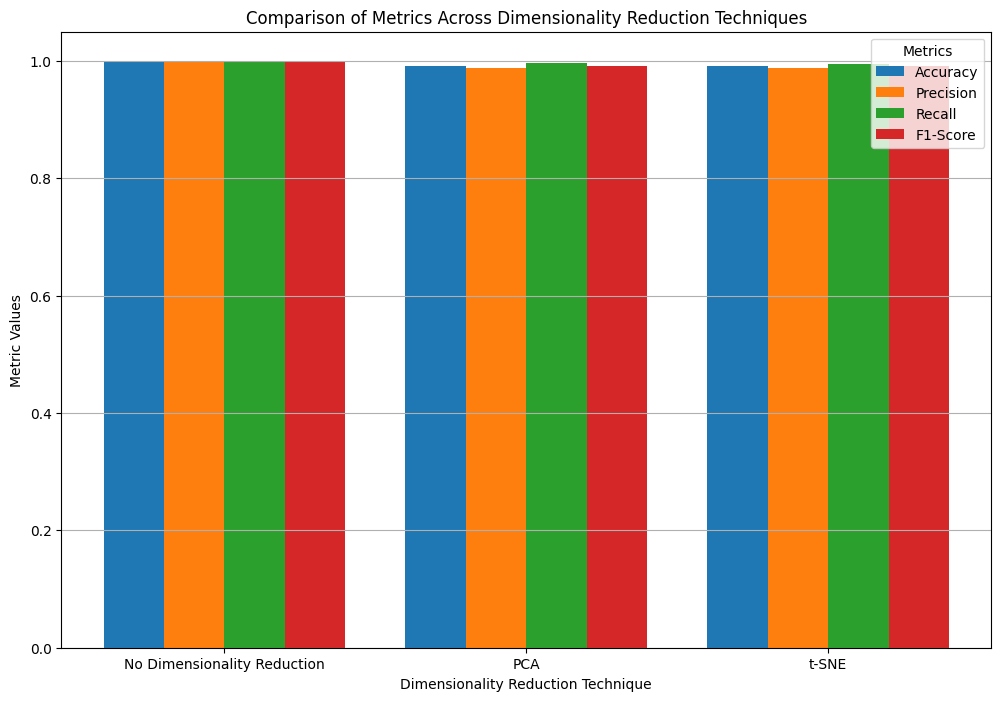

In [ ]:
# run for no dimensionality reduction
metrics_no_reduction = run_dimensionality_reduction_and_cv(
    X_scaled, y, method=None,
    n_estimators=best_n_estimators_no_reduction, max_depth=best_max_depth_no_reduction
)

# run for PCA
metrics_pca = run_dimensionality_reduction_and_cv(
    X_scaled, y, method="PCA",
    n_estimators=best_n_estimators_pca, max_depth=best_max_depth_pca, pca_threshold=best_pca_threshold
)

# run for t-SNE
metrics_tsne = run_dimensionality_reduction_and_cv(
    X_scaled, y, method="TSNE",
    n_estimators=best_n_estimators_tsne, max_depth=best_max_depth_tsne, tsne_perplexity=best_tsne_perplexity
)

# collect metrics for plotting
methods = ["No Dimensionality Reduction", "PCA", "t-SNE"]
metrics_labels = ["Accuracy", "Precision", "Recall", "F1-Score"]

# create list to store metrics
metrics_list = [metrics_no_reduction, metrics_pca, metrics_tsne]

# convert metrics_list to a NumPy array for easy indexing
scores = np.array(metrics_list)

# define data and labels
x = np.arange(len(methods))
width = 0.2  

plt.figure(figsize=(12, 8))
for i, metric_label in enumerate(metrics_labels):
    plt.bar(x + i * width, scores[:, i], width, label=metric_label)

plt.title("Comparison of Metrics Across Dimensionality Reduction Techniques")
plt.ylabel("Metric Values")
plt.xlabel("Dimensionality Reduction Technique")
plt.xticks(x + width * 1.5, methods)
plt.legend(title="Metrics")
plt.grid(axis='y')
plt.show()



After running a CV that compares the different reduction techniques, the model performs extremely well regardless of which approach is chosen. However, the unreduced dataset performs slightly better than the datasets with their dimensions reduced. This might be because the reduction is removing important information and the model is able to handle the extra noise well.

### Test Set Evaluation
The following block evaluates the test set after it has been trained on models using data altered by either PCA, t-SNE, or no dimension reduction.

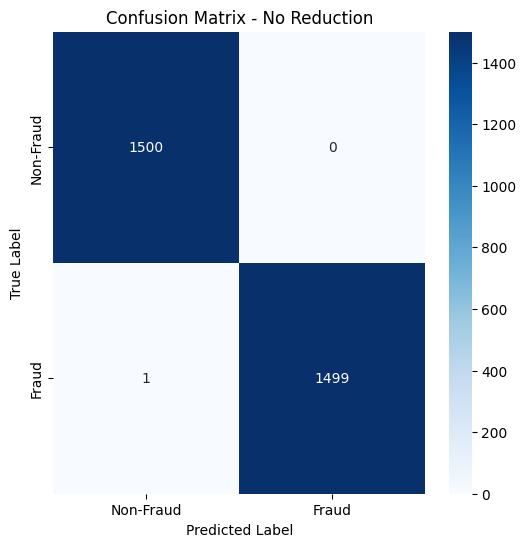

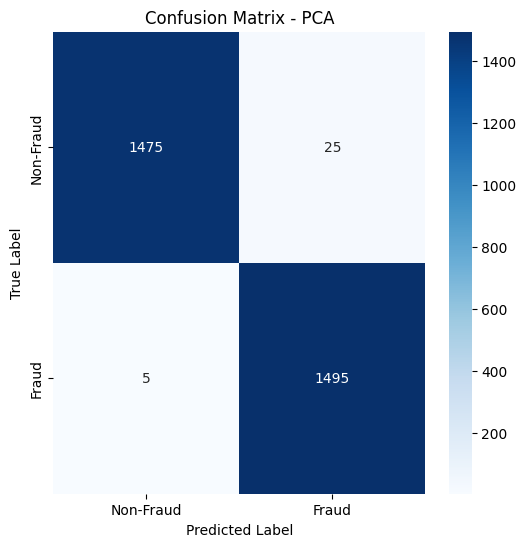

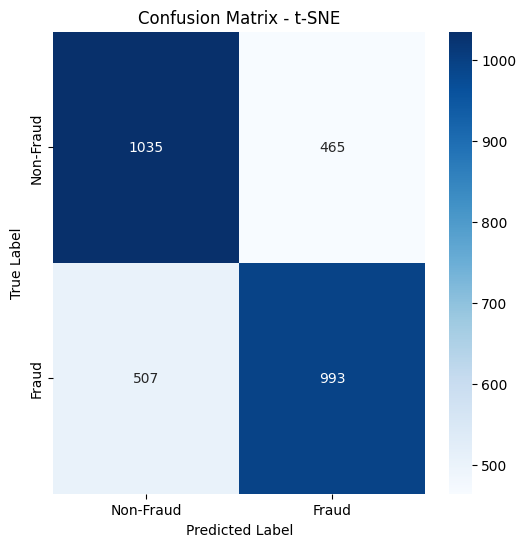

In [ ]:
# split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# evaluate No Reduction and plot the confusion matrix
cm_no_red, _, _, rf_no_red = evaluate_on_test_set(
    X_train, y_train, X_test, y_test, method=None,
    n_estimators=best_n_estimators_no_reduction, max_depth=best_max_depth_no_reduction
)
plot_conf_matrix(cm_no_red, title="Confusion Matrix - No Reduction")

# evaluate PCA and plot the confusion matrix
cm_pca, X_test_pca, y_pred_pca, rf_pca = evaluate_on_test_set(
    X_train, y_train, X_test, y_test, method="PCA",
    n_estimators=best_n_estimators_pca_refined, max_depth=best_max_depth_pca_refined,
    pca_threshold=best_pca_threshold
)
plot_conf_matrix(cm_pca, title="Confusion Matrix - PCA")

# evaluate t-SNE and plot the confusion matrix
cm_tsne, X_test_tsne, y_pred_tsne, rf_tsne = evaluate_on_test_set(
    X_train, y_train, X_test, y_test, method="t-SNE",
    n_estimators=best_n_estimators_tsne_refined, max_depth=best_max_depth_tsne_refined,
    tsne_perplexity=best_tsne_perplexity
)
plot_conf_matrix(cm_tsne, title="Confusion Matrix - t-SNE")


The dataset with no dimensionality reduction performed slightly better than the PCA reduced dataset, but both of these datasets were very reliable and had high rates of true positives and true negatives. Dimension reduction with t-SNE offered a substantial decrease in performance, identifiying many more false positives and false negatives. t-SNE is more focused on data visualization rather than improving the rate of classification. One problem with t-SNE is that it always reduces to 2 dimensions which could lead to a large loss of relevent information and a less accurate model. 